<a href="https://colab.research.google.com/github/vovkinson/colabs/blob/main/SBERT_for_classic_problem_solving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Использование моделей естественного языка SBERT для Ваших задач

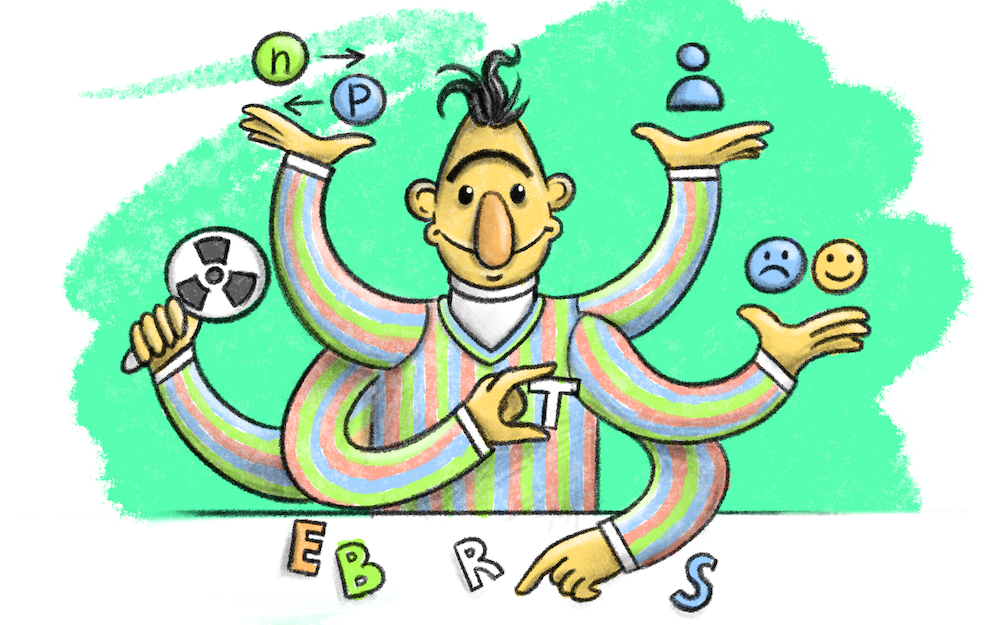

**Обработка естественного языка (Natural Language Processing, NLP)** – это область вычислительной лингвистики, ориентированная на разработку машин, способных понимать человеческие языки. Разработка таких машин – одна из задач, которые решают исследователи и инженеры в команде SberDevices.

В современной компьютерной лингвистике понимание смысла написанного или сказанного достигается с помощью векторных моделей естественного языка. Например, в семействе виртуальных ассистентов Салют такая модель применяется для распознавания намерений пользователя, ведения диалога, выделения именованных сущностей и многих других задач.


### О чем этот гайд

Сегодня мы рассмотрим возможные варианты использования модели естественного языка (NLU) для русского домена на примере нашей разработки **Ru-SBERT**
(подробнее https://habr.com/ru/company/sberdevices/blog/527576/ ), саму модель можно найти на нашем любимом [Huggingface](https://huggingface.co/sberbank-ai/sbert_large_nlu_ru).

В качестве демонстрационных задач рассмотрим: определение токсичности комментариев соревнования OK.RU, поиск новостей по данным из соревнований DIALOGUE


*План работы:*

0. Ввведение. Установка необходимых пакетов и скачивание данных

1. Подготовим данные OK.RU и Диалог для работы

2. Загрузим модели SBERT с репо SberDevices в HuggingFace и подготовим обработчики текста.

3. Рассмотрим задачу семантического поиска по вектору заголовка новостей с использованием векторов SBERT и numpy.

4. BONUS. Ускорение поиска новостей с FAISS + SBERT

4. Опробуем модели sklearn + SBERT вектора для задачи классификации токсик сообщений.

5. BONUS. Улучшение качества классификации с Pytorch NN + SBERT

### Что такое SBERT?
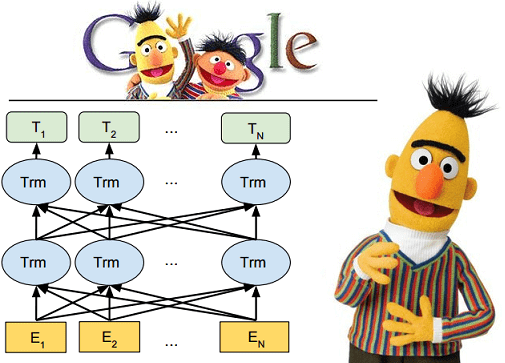

**BERT** - это модель из семейства **трансформеров** поэтому чтобы понять, что это такое, нужно поговорить именно о transformers

Если просто и схематично это выглядит вот так

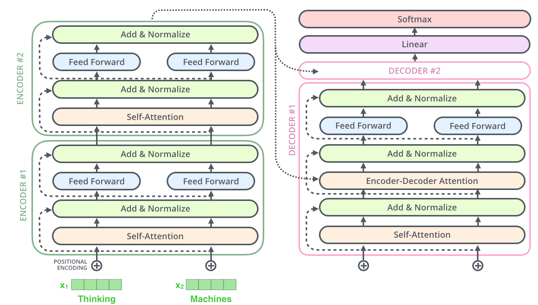

На вход это чудо NN мысли получает текст а на выходе выдает вектора каждого "слова" наполненные смыслом: позиционности, контекста, тематики, семантики, тональности и тп.

Как такое получается? Если просто то так =)

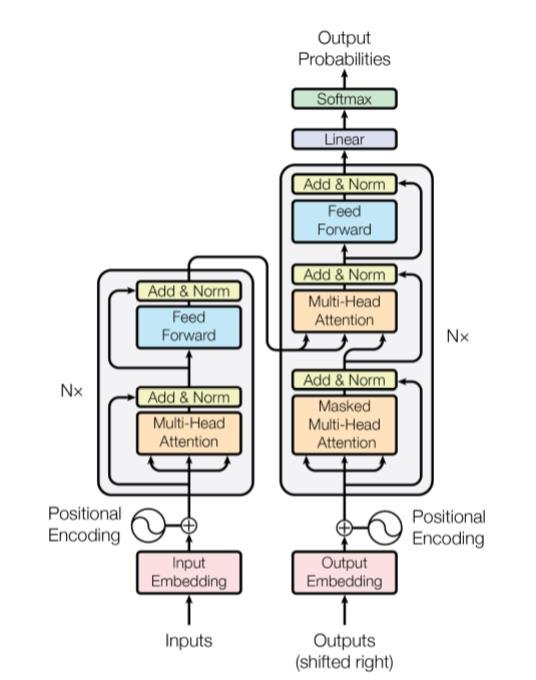

### LOAD DATA

Загрузим данные токсик и новостных лент

In [ ]:
!nvidia-smi

Tue Jun 14 14:13:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |   4918MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://cups.mail.ru/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo  -O toxic.csv

--2022-06-14 14:13:57--  https://cups.mail.ru/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo
Resolving cups.mail.ru (cups.mail.ru)... 188.93.56.95
Connecting to cups.mail.ru (cups.mail.ru)|188.93.56.95|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cups.online/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo [following]
--2022-06-14 14:13:57--  https://cups.online/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo
Resolving cups.online (cups.online)... 188.93.56.95
Connecting to cups.online (cups.online)|188.93.56.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24525472 (23M) [application/octet-stream]
Saving to: ‘toxic.csv’

toxic.csv           100%[===================>]  23.39M  12.5MB/s    in 1.9s    

2022-06-14 14:14:00 (12.5 MB/s) - ‘toxic.csv’ saved [24525472/24525472]



In [ ]:
!head toxic.csv

41127	__label__THREAT	дворника надо тоже уничтожить!
6812	__label__NORMAL	моя старшая неделю шипела, не принимала подкидыша, которого я принесла. китя такой славный, потерпите немного, мои теперь душа в душу живут, ваша примет попозже. а котенок необыкновенно красивый.
6256	__label__NORMAL	полностью с вами согласна!
189636	__label__NORMAL	хоть ногу вверх, ничего не изменится
99053	__label__NORMAL	а что значит - левого ребенка?
98418	__label__NORMAL	вечер добрый! а, что он у вас уже постарел?!
3619	__label__NORMAL	какая порода .?
176463	__label__INSULT	спасатель? просто петух чванливый, взял наших пацанов в заложники и торгуется. позор! как бы сам в щи не попал.
13520	__label__NORMAL	с замечательным юбилеем!!! голос- чудо, заслушаешься 😍и про чтение все правильно- ничто не сравнится с бумажной книгой!
133613	__label__NORMAL	еще бы .такой красавец.


In [ ]:
!wget http://paraphraser.ru/download/get?file_id=7 -O paraphrase.zip

--2023-10-16 16:43:00--  http://paraphraser.ru/download/get?file_id=7
Resolving paraphraser.ru (paraphraser.ru)... 91.122.14.248
Connecting to paraphraser.ru (paraphraser.ru)|91.122.14.248|:80... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-10-16 16:43:01 ERROR 403: Forbidden.



In [ ]:
!unzip paraphrase.zip

Archive:  paraphrase.zip
   creating: ParaPhraserPlus/
  inflating: ParaPhraserPlus/ParaPhraserPlus.json  


### INSTALL PACKAGES

In [ ]:
!pip install transformers
!pip install faiss-gpu
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.3 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 101 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 29.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=460c3d0603335ce0e45b811139ceccb357fb26f4b3f464a324e4ab0c6e2b

In [ ]:
import re
import os
import sys
import json
import nltk
from tqdm import tqdm
import gc

import logging
import numpy as np
import pandas as pd

from scipy.stats import spearmanr, pearsonr
from glob import glob

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import faiss

### SEMANTIC SEARCH

**SBERT** - это развитие *BERT* модели, которая обладает важным свойством: она хорошо **сближает фразы схожием по смыслу**, но разные по написанию. Это свойство позволяет эффективно использовать представления текста в виде вектора для семантического поиска.

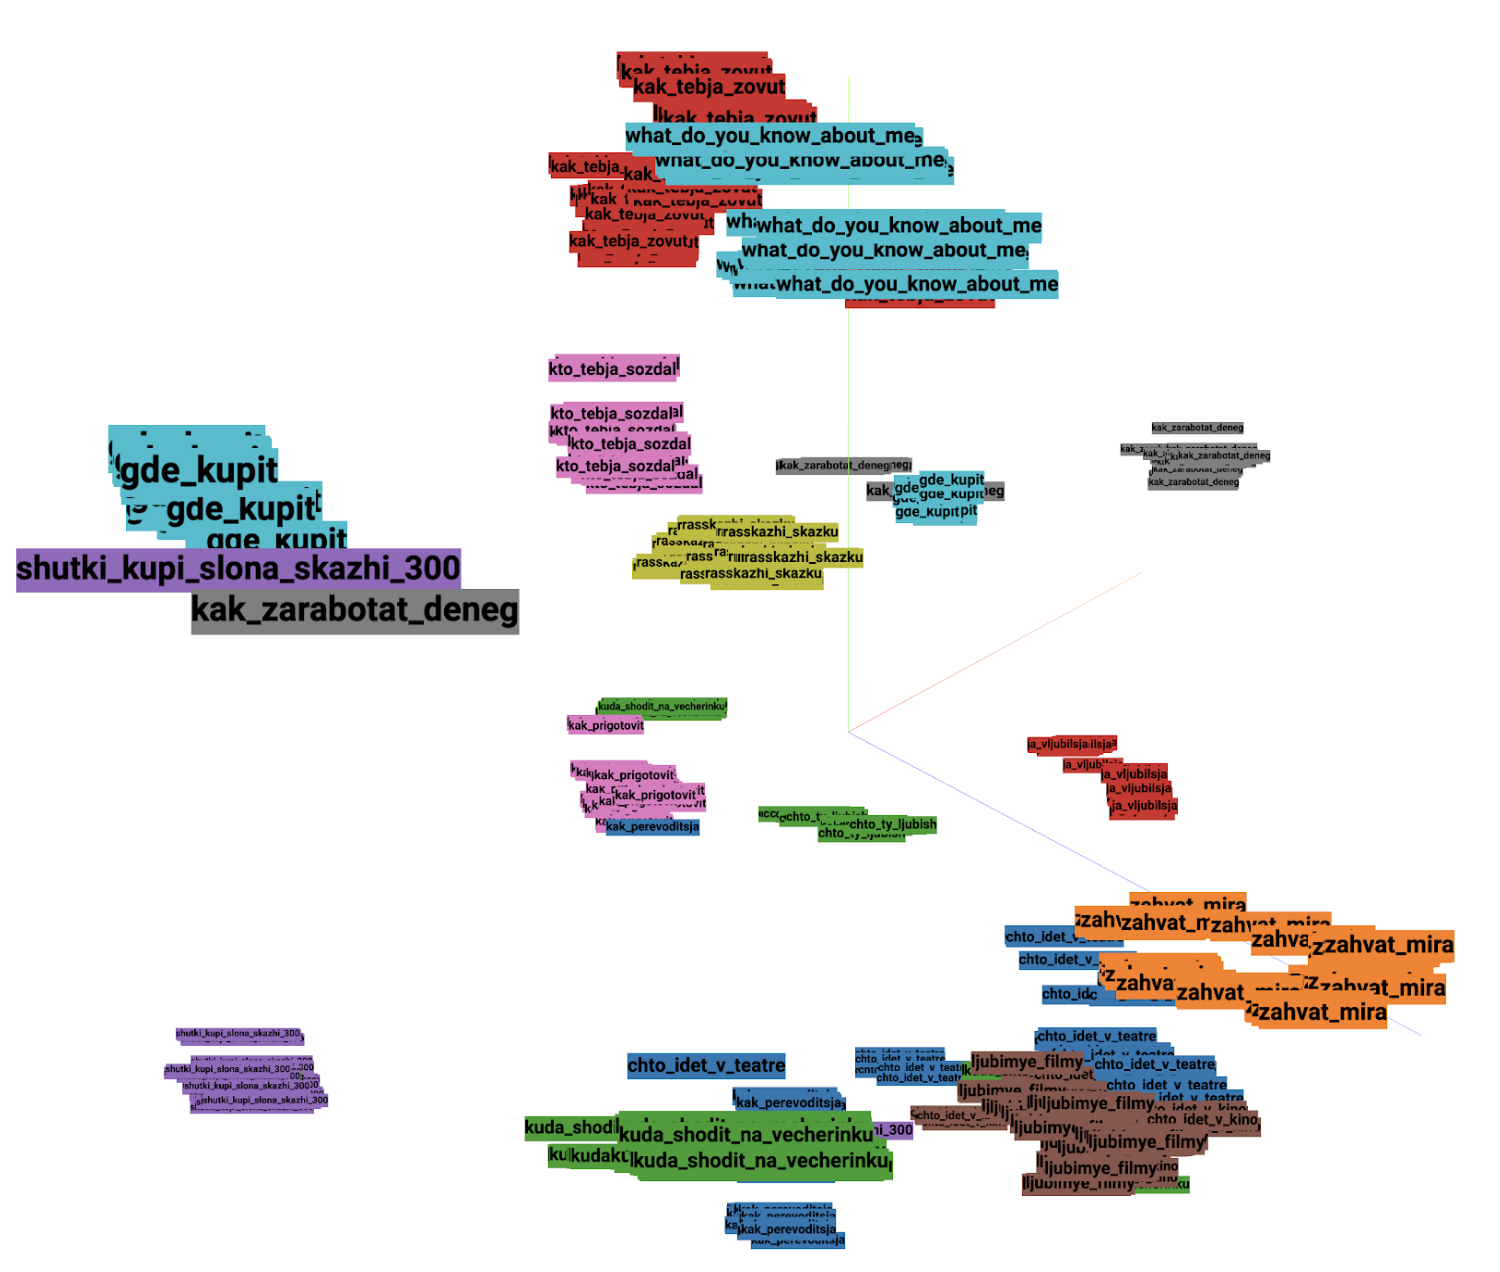




In [ ]:
with open('//content/ParaPhraserPlus/ParaPhraserPlus.json', 'r') as f:
    para=json.load(f)

In [ ]:
#пример текста который хранит json
#date - дата публикации
#headlines - заголовки новости в разных источниках
#rubric - домен новостей
para['10']

{'date': '2019/01/02',
 'headlines': ['Минобороны РФ анонсировало самое крупное в 2019 году зимнее учение в Поволжье',
  'Полигон в Рощинском примет самые крупные зимние военные учения'],
 'rubric': 'общество'}

In [ ]:
rubrics = []
for k in para.keys():
  r = para[k]['rubric']
  if r in rubrics:
    continue
  else:
    rubrics.append(r)
print('лист рубрик', rubrics)

лист рубрик ['общество', 'спорт', 'региональные', 'происшествия', 'конфликты', 'зарубежные', 'политика', 'наука', 'культура', 'экономика', 'события', 'медиа', 'авто', 'жкх', 'здоровье', 'животные']


In [ ]:
print('число инфоповодов' , len(para.keys()))

число инфоповодов 1725393


  Для примера предлагаем взять одну рубрику и в рамках нее осуществить семантический поиск.
  Пусть это будет рубрика "наука".

In [ ]:
science_news = []

for k in para.keys():
  r = para[k]['rubric']
  if r=='наука':
    science_news+=para[k]['headlines']
  else:
    continue
print('рубрика наука', len(science_news))

рубрика наука 84443


##### embeddings function

In [ ]:
class Data(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = np.array(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        return text

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def get_embeddings(df, model, tokenizer, bsize=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
    model.to(device)
    model.eval()
    ldr_data = Data(data = df)
    loader = DataLoader(dataset = ldr_data, shuffle=False, batch_size = min([bsize, len(df)]))
    embeddings = []
    with torch.no_grad():
        for i, inputs in tqdm(enumerate(loader)):
            ##Tokenize sentences
            batch = tokenizer(list(inputs), truncation=True, padding=True, return_tensors='pt', max_length=24)
            input_ids = batch['input_ids']
            input_ids = input_ids.to(device, dtype=torch.long)
            batch['input_ids'] = input_ids

            token_type_ids = batch['token_type_ids']
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            batch['token_type_ids'] = token_type_ids

            attention_mask = batch['attention_mask']
            attention_mask = attention_mask.to(device, dtype=torch.long)
            batch['attention_mask'] = attention_mask

            #Compute token embeddings
            preds = model(**batch)
            #Perform pooling. In this case, mean pooling
            preds = mean_pooling(preds, attention_mask)
            outputs = preds.cpu().detach().numpy()
            embeddings.extend(outputs)
    return np.array(embeddings)


#Sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")  #sberbank-ai/sbert_large_mt_nlu_ru
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

##Tokenize sentences
#encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

#Compute token embeddings
#with torch.no_grad():
#    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
#sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

In [ ]:
sentences = ['Привет! Как твои дела?',
             'Как тваи елишки малышкО', 'Хачу гулять лео ведь']

In [ ]:
sentence_embeddings = get_embeddings(sentences, model, tokenizer, bsize = 256)

cuda is used


1it [00:00, 23.83it/s]


In [ ]:
np.dot(sentence_embeddings[0], sentence_embeddings[1])

121.20256

In [ ]:
sentence_embeddings

array([[ 0.4586771 , -0.2511485 , -0.45541745, ...,  0.32620454,
        -0.98523265,  0.20712778],
       [ 0.50019795, -0.04580222, -0.6035451 , ...,  0.34603205,
        -0.30684248,  0.28612503]], dtype=float32)

In [ ]:
sentence_embeddings = get_embeddings(science_news, model, tokenizer, bsize=1024)

cuda is used


83it [06:26,  4.66s/it]


In [ ]:
gc.collect()

52

In [ ]:
sentence_embeddings.shape

(84443, 1024)

In [ ]:
def sem_search(q, d_embs, values, bsize = 1024, top_k=5):
  query = get_embeddings(q, model, tokenizer, bsize=bsize)
  sim = np.matmul(query, d_embs.T)
  resp = values[np.argsort(-1*sim)[0][:top_k]]
  return resp

In [ ]:
sem_search(q=['сверхпроводимость открытия'],
           d_embs=sentence_embeddings,
           values = np.array(science_news),
           top_k=5)

cuda is used


1it [00:00, 41.65it/s]


array(['Нобелевские лауреаты Гейм и Новоселов открыли способ применения графена для увеличения скорости Интернета',
       'Открытый россиянами графен в сотни раз увеличит скорость работы интернета',
       'На Большом адронном коллайдере ученым впервые удалось получить стабильные атомы антиматерии',
       'Большой адронный коллайдер продемонстрировал новую физику частиц',
       'Открытие НАСА: 7 потенциально обитаемых экзопланет'],
      dtype='<U359')

#### Почему SBERT так хорош в поиске?
При тюнинге BERT мы используем metric - learning подход. Metric learning это способ обучения нейросетей на основе какой-то функции близости, в случае с SBERT мы заставляем модель сводить вектора BERT для фраз схожих по смыслу и разводить слова похожие по написанию но по смыслу различные.

Для этого мы используем **Siamese Network** подход с **triplet-loss**:



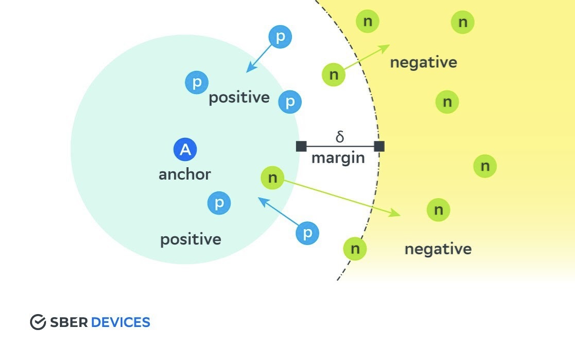

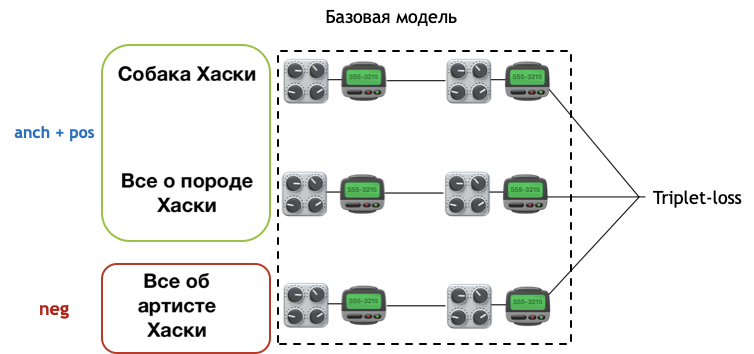

In [ ]:
gc.collect()

211

#### UMAP maps of news rubrics

In [ ]:
def get_rndm_rubrics_data(rbrc, size=100):
  science_news = []
  for k in para.keys():
    r = para[k]['rubric']
    if r==rbrc:
      science_news+=para[k]['headlines']
    else:
      continue

  res = np.random.choice(science_news, size=size)
  del(science_news)
  gc.collect()

  return res

In [ ]:
umap_test_txt = {}
for rubr in ['спорт', 'наука', 'политика','здоровье','общество']:
  umap_test_txt[rubr]=get_rndm_rubrics_data(rubr)

In [ ]:
embs_all = [get_embeddings(umap_test_txt[rubr], model, tokenizer, bsize = 128) for rubr in ['спорт', 'наука', 'политика','здоровье','общество']]

cuda is used


1it [00:00,  1.04it/s]


cuda is used


1it [00:00,  1.12it/s]


cuda is used


1it [00:00,  1.09it/s]


cuda is used


1it [00:00,  1.10it/s]


cuda is used


1it [00:00,  1.10it/s]


In [ ]:
embs_all = np.vstack(embs_all)
gc.collect()

326

In [ ]:
labels = [ [rubr]*100 for i, rubr in enumerate(['спорт', 'наука', 'политика','здоровье','общество'])]
labels=np.hstack(labels)

In [ ]:
from umap import UMAP
import plotly.express as px

features = embs_all

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=labels, labels={'color': 'rubrics'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=labels, labels={'color': 'rubrics'}
)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [ ]:
fig_2d.show()

In [ ]:
fig_3d.update_traces(marker_size=3)
fig_3d.show()

#### **BONUS FAISS search**
FAISS - это билиотека для хранения и быстрого поиска данных по их векторному представлению (кешу). Работа алгоритма строится на апроксимации ближайших соседей кластерными центроидами именно они составляют поисковый индекс и уменьшают сложность поиска.

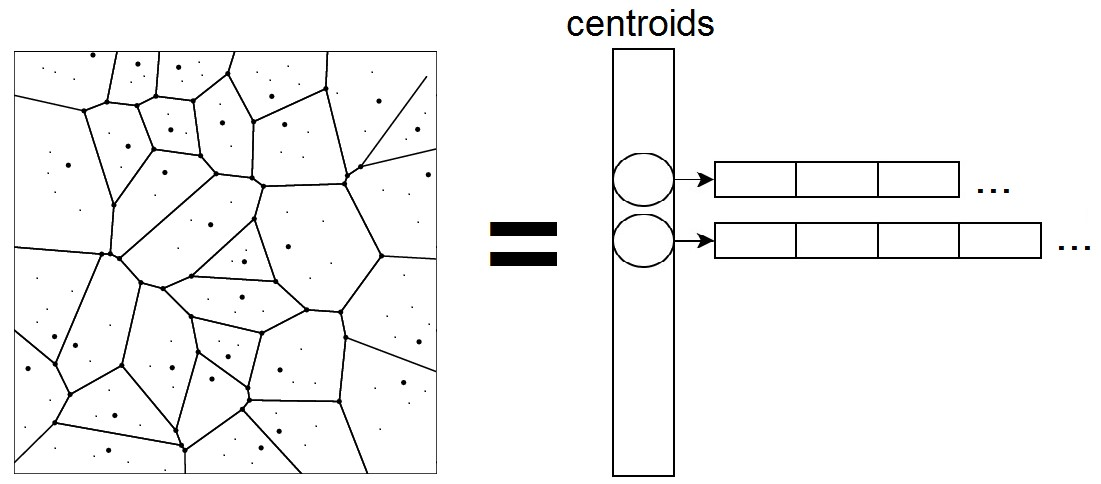

Подробнее о FAISS можно почитать на сайте разработчика [facebook](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/)

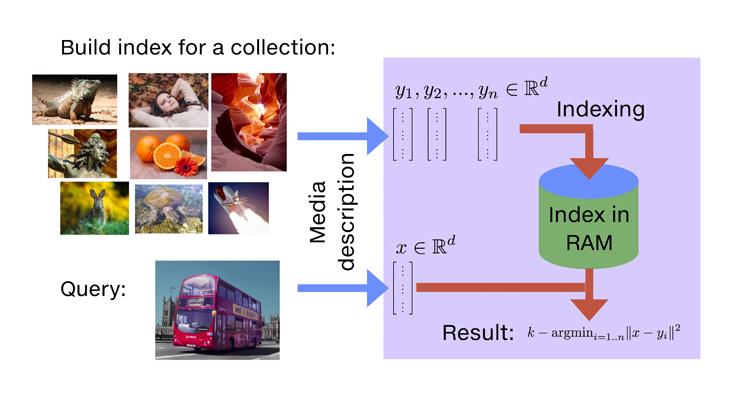


In [ ]:
import math
dim = sentence_embeddings.shape[1] #передаем размерность пр-ва
size = sentence_embeddings.shape[0] #размер индекса

In [ ]:
MODE = 'DOT'

if MODE == 'DOT':
  #тк мы в SBERT тюним dot prod loss эффективнее такой подход

  metric = faiss.METRIC_INNER_PRODUCT
  nlist = min(4096, 8 * round(math.sqrt(size)))
  if size < 100 * 10000:
          fac_str = "Flat"  # same
  elif size < 200 * 10000:
          fac_str = "IVF" + str(nlist) + ",Flat"  # same
  elif size < 500 * 10000:
          fac_str = "IVF16384,Flat"  # same
  else:
          fac_str = "IVF16384,PQ8"  # same


  nprobe = 8
  index = faiss.index_factory(dim, fac_str, metric)
  index.train(sentence_embeddings)
  index.nprobe = min(nprobe, nlist)
  assert index.is_trained
  index.add(sentence_embeddings)

else:
  # ОДНАКО можно и по классике искать Евклидово расстояние
  index = faiss.IndexFlatL2(dim)
  print(index.ntotal)  # пока индекс пустой
  index.add(sentence_embeddings)
  print(index.ntotal)  # теперь в нем sentence_embeddings.shape[0] векторов

In [ ]:
query = get_embeddings(['Искуственный интеллект'], model, tokenizer, bsize=1024)

cuda is used


1it [00:00, 18.25it/s]


In [ ]:
topn = 5
D, I = index.search(query, topn)  # Возвращает результат: Distances, Indices
print(I)
print(D)

[[44566 78526 78522 44568 44567]]
[[234.73544 234.72173 222.82692 222.74371 218.29385]]


In [ ]:
# Создадим поиск с помощью FAISS
def sem_search_faiss(q, index, values, top_k=5):
  query = get_embeddings(q, model, tokenizer, bsize=1024)
  D, I = index.search(query, top_k)
  resp = np.array(values)[I]
  return resp

In [ ]:
sem_search_faiss(
           q=['Искуственный интеллект'],
           index=index,
           values = np.array(science_news),
           top_k=5
           )

cuda is used


1it [00:00, 19.59it/s]


array([['Создан искусственный интеллект, превосходящий человека в интуиции',
        'Создан искусственный интеллект способный на самостоятельную эволюцию',
        'Создан искусственный разум, способный к эволюции',
        'Ученые создали искусственный интеллект с невероятной интуицией',
        'Ученые создали искусственный интеллект, превосходящий человека в интуиции']],
      dtype='<U359')

### TOXIC classification

Для начала попробуем использовать эмбеддинги СБЕРТ как есть в связке с логрегрессией из sklearn

Почему SBERT хорош для toxic задач? При обучении мы так же добавляем триплеты токсичных фраз, чтобы они группировались в своей области пространства далеко от нормальных запросов

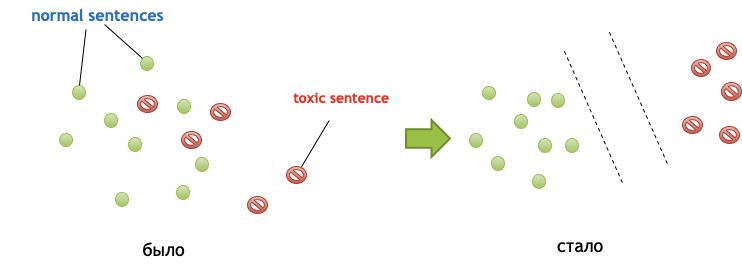

In [ ]:
import csv
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score


strs = []
#считаем файл - осторожно есть ошибки чтения
#ввиду сломанного формата записи некоторых строк
#поэтому введем ограничение на длину строки 3 - индекс,лейбл,текст

with open('toxic.csv', newline='\n') as csvfile:
     spamreader = csv.reader(csvfile, delimiter='\t')
     for row in spamreader:
         if len(row)<=3:
           strs.append(row)

In [ ]:
strs = np.vstack(strs)

tox_df = pd.DataFrame({'id':strs[:,0],
              'label': strs[:,1],
              'text':strs[:,2]})

In [ ]:
tox_df

,id,label,text
0,41127,__label__THREAT,дворника надо тоже уничтожить!
1,6812,__label__NORMAL,"моя старшая неделю шипела, не принимала подкид..."
2,6256,__label__NORMAL,полностью с вами согласна!
3,189636,__label__NORMAL,"хоть ногу вверх, ничего не изменится"
4,99053,__label__NORMAL,а что значит - левого ребенка?
...,...,...,...
143782,99767,__label__NORMAL,"а вы думаете что полиция об этом не знает, про..."
143783,87456,__label__NORMAL,"ну а что вы тут возмущаетесь , все ведь точно ..."
143784,185614,__label__NORMAL,затерли до дыр данный ролик сколько лет ему уж...
143785,86412,__label__INSULT,если проследят за пидором то накажут


In [ ]:
# Зачистим немного кеша
del(sentence_embeddings, index, para)
gc.collect()

35955

In [ ]:
label_dct

{'__label__INSULT': 2,
 '__label__NORMAL': 1,
 '__label__OBSCENITY': 3,
 '__label__THREAT': 0}

In [ ]:
# приведем данные в удобный для обучения формат
label_dct = {t: i for i, t in enumerate(tox_df.label.unique())}
tox_label = tox_df.label.map(lambda x: label_dct[x])

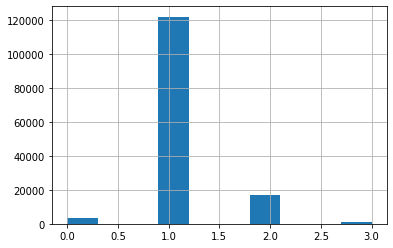

In [ ]:
tox_df['target']=tox_label
tox_df.target.hist()

In [ ]:
# получим вектора текстов при помощи Ru-SBERT
tox_embs = get_embeddings(tox_df.text[:10000], model, tokenizer, bsize=1024)
gc.collect()

cuda is used


10it [01:28,  8.80s/it]


72

In [ ]:
# т.к. задача классификации на нескольких несбалансированных метках создадим хитрую валидацию
# в качестве метрики рассмотрим F1 меру - микро и макро
f1_scorer = make_scorer(f1_score, average='micro')

skf = StratifiedKFold(n_splits=5)

In [ ]:
X, y = tox_embs,tox_label[:10000]

cross_val_score(
    SGDClassifier(random_state=42,loss='log', n_jobs=-1),
    X, y,
    scoring=f1_scorer,
    cv=skf, n_jobs=-1)

array([0.9175, 0.918 , 0.9265, 0.915 , 0.92  ])

In [ ]:
gc.collect()

317

In [ ]:
f1_scorer = make_scorer(f1_score, average='macro')

cross_val_score(
    LogisticRegression(random_state=42, n_jobs=-1),
    X, y,
    scoring=f1_scorer,
    cv=skf, n_jobs=-1)

array([0.80757235, 0.81084501, 0.79369432, 0.81559448, 0.82441175])

### BONUS TOXIC WITH MLP PyTorch

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
import random
from transformers import PreTrainedModel, BertConfig, AdamW, get_constant_schedule_with_warmup
import torch
import torch.nn as nn

In [ ]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

seed = 82
random_state = set_seed(seed)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
model_config = BertConfig.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

In [ ]:
model_config

BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 120138
}

In [ ]:
class Data(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.text[idx]
        target = self.data.target[idx]
        return text, target

#tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
#model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

class ToxicModel(PreTrainedModel):
    def __init__(self, conf):
        super(ToxicModel, self).__init__(conf)
        self.sbert = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru",
                                               config=conf)
        self.drop_out = nn.Dropout(0.2)
        self.d1 = nn.Linear(1024 , 768)
        self.d2 = nn.ReLU()
        self.d3 = nn.Linear(768, 768)
        self.l1 = nn.Linear(768, 4)
        torch.nn.init.normal_(self.l1.weight, std=0.02)

    def mean_pooling(self, model_output, attention_mask, sqrt_mode=None):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        token_embeddings = self.drop_out(token_embeddings)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        pool = sum_embeddings / torch.sqrt(sum_mask) if sqrt_mode else sum_embeddings / sum_mask
        return pool

    def forward(self, batch):
        out = self.sbert(
            **batch
        )
       # out = out[0]
        out = self.mean_pooling(out, batch['attention_mask'], sqrt_mode= False)
        out = self.drop_out(out)
        #mean = torch.mean(out, 0, False)
        out = self.d1(out)
        out = self.d2(out)
        out = self.drop_out(out)

        preds = self.l1(out)

        #preds = preds.squeeze(-1)
        return preds

In [ ]:
tox_df['fold']=0

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

In [ ]:
tox_df = tox_df.sample(5000, replace=False).reset_index(drop=True)

In [ ]:
tox_df.shape

(25000, 4)

In [ ]:
for fold, (train, val) in enumerate(skf.split(tox_df.text, tox_df.target)):
    try:
        del(model)
        gc.collect()
    except:
        pass

    print('-----',fold,'-----')
    tox_df.loc[val,'fold']=fold
    val_df = tox_df.loc[val].reset_index(drop=True)
    tr_df = tox_df.loc[train].reset_index(drop=True)

    bst_score = -999

    train_data = Data(data = tr_df)
    train_loader = DataLoader(dataset = train_data, shuffle=True, batch_size = 64)

    val_data = Data(data = val_df)
    val_loader = DataLoader(dataset = val_data, shuffle=False, batch_size = 64)

    model = ToxicModel(model_config)
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    scheduler = get_constant_schedule_with_warmup(optimizer, 100)

    criterion=nn.CrossEntropyLoss()

    epochs = 5

    for epoch in range(epochs):
        model.train()
        for i, (inputs, targets) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            targets=torch.tensor(targets).to(device, dtype=torch.long)

            batch = tokenizer(list(inputs), truncation=True, padding=True, return_tensors='pt', max_length=24)
            input_ids = batch['input_ids']
            input_ids = input_ids.to(device, dtype=torch.long)
            batch['input_ids'] = input_ids

            token_type_ids = batch['token_type_ids']
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            batch['token_type_ids'] = token_type_ids

            attention_mask = batch['attention_mask']
            attention_mask = attention_mask.to(device, dtype=torch.long)
            batch['attention_mask'] = attention_mask

            preds = model(batch)

            loss = criterion(preds, targets)

            loss.backward()
            optimizer.step()
            scheduler.step()
            loss = loss.item()

            if i==0:
                loss_train = loss
            else:
                loss_train = loss_train + loss
        loss_train = loss_train/(i+1)

        model.eval()
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(tqdm(val_loader)):
                optimizer.zero_grad()
                batch = tokenizer(list(inputs), truncation=True, padding=True, return_tensors='pt', max_length=24)

                input_ids = batch['input_ids']
                input_ids = input_ids.to(device, dtype=torch.long)
                batch['input_ids'] = input_ids

                token_type_ids = batch['token_type_ids']
                token_type_ids = token_type_ids.to(device, dtype=torch.long)
                batch['token_type_ids'] = token_type_ids

                attention_mask = batch['attention_mask']
                attention_mask = attention_mask.to(device, dtype=torch.long)
                batch['attention_mask'] = attention_mask

                targets=torch.tensor(targets).to(device, dtype=torch.long)

                preds = model(batch)

                loss = criterion(preds, targets)
                loss = loss.item()

                preds = preds.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                if i==0:
                    loss_val = loss
                    preds_val = np.argmax(preds, axis=1)
                    targets_val = targets
                else:
                    loss_val = loss_val + loss
                    preds_val = np.concatenate((preds_val, np.argmax(preds, axis=1)), axis=None)
                    targets_val = np.concatenate((targets_val,targets), axis=None)

            loss_val = loss_val / (i+1)
            f1_val = f1_score(targets_val, preds_val, average='micro')
            print('Epoch: {} - Loss: {:.6f} - Loss val: {:.6f} - F1: {:.3f}'.format(
                epoch + 1, loss_train, loss_val, f1_val))

            if f1_val>=bst_score:
                #if you wanna save model uncomment this code!
                torch.save(model.state_dict(), 'sbert_'+str(fold)+'.bin')
                bst_score=f1_val
            else:
                pass

----- 0 -----


100%|██████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch: 1 - Loss: 0.378581 - Loss val: 0.134121 - F1: 0.959


100%|██████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch: 2 - Loss: 0.100216 - Loss val: 0.110790 - F1: 0.966


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Epoch: 3 - Loss: 0.055120 - Loss val: 0.137892 - F1: 0.959


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Epoch: 4 - Loss: 0.031966 - Loss val: 0.138244 - F1: 0.964


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Epoch: 5 - Loss: 0.018667 - Loss val: 0.196839 - F1: 0.954
----- 1 -----


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Epoch: 1 - Loss: 0.414611 - Loss val: 0.135073 - F1: 0.957


100%|██████████| 79/79 [00:45<00:00,  1.74it/s]


Epoch: 2 - Loss: 0.105248 - Loss val: 0.125564 - F1: 0.960


100%|██████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch: 3 - Loss: 0.059192 - Loss val: 0.131649 - F1: 0.965


100%|██████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch: 4 - Loss: 0.035460 - Loss val: 0.138243 - F1: 0.962


100%|██████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch: 5 - Loss: 0.023742 - Loss val: 0.190084 - F1: 0.964
----- 2 -----


100%|██████████| 79/79 [00:45<00:00,  1.72it/s]


Epoch: 1 - Loss: 0.408023 - Loss val: 0.138948 - F1: 0.957


100%|██████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch: 2 - Loss: 0.105182 - Loss val: 0.111528 - F1: 0.968


100%|██████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch: 3 - Loss: 0.057157 - Loss val: 0.122632 - F1: 0.963


100%|██████████| 79/79 [00:45<00:00,  1.73it/s]


Epoch: 4 - Loss: 0.032972 - Loss val: 0.151611 - F1: 0.964


 16%|█▋        | 51/313 [01:33<07:57,  1.82s/it]

## Выводы
1. Мы познакомились с моделью векторизации текста от SberDevices ru-SBERT
2. Узнали как использовать модели SBERT для семантического поиска с использованием Numpy, FAISS
3. Научились доступно визуализировать результаты векторизации по доменам при помощи UMAP
4. Использовали вектора SBERT для обучения модели LogRegression из Sklearn. Получили из коробки достойные результаты на токсик данных.
5. Попробовали улучшить результаты из коробки с помощью нейросетей и инструмента PyTorch.





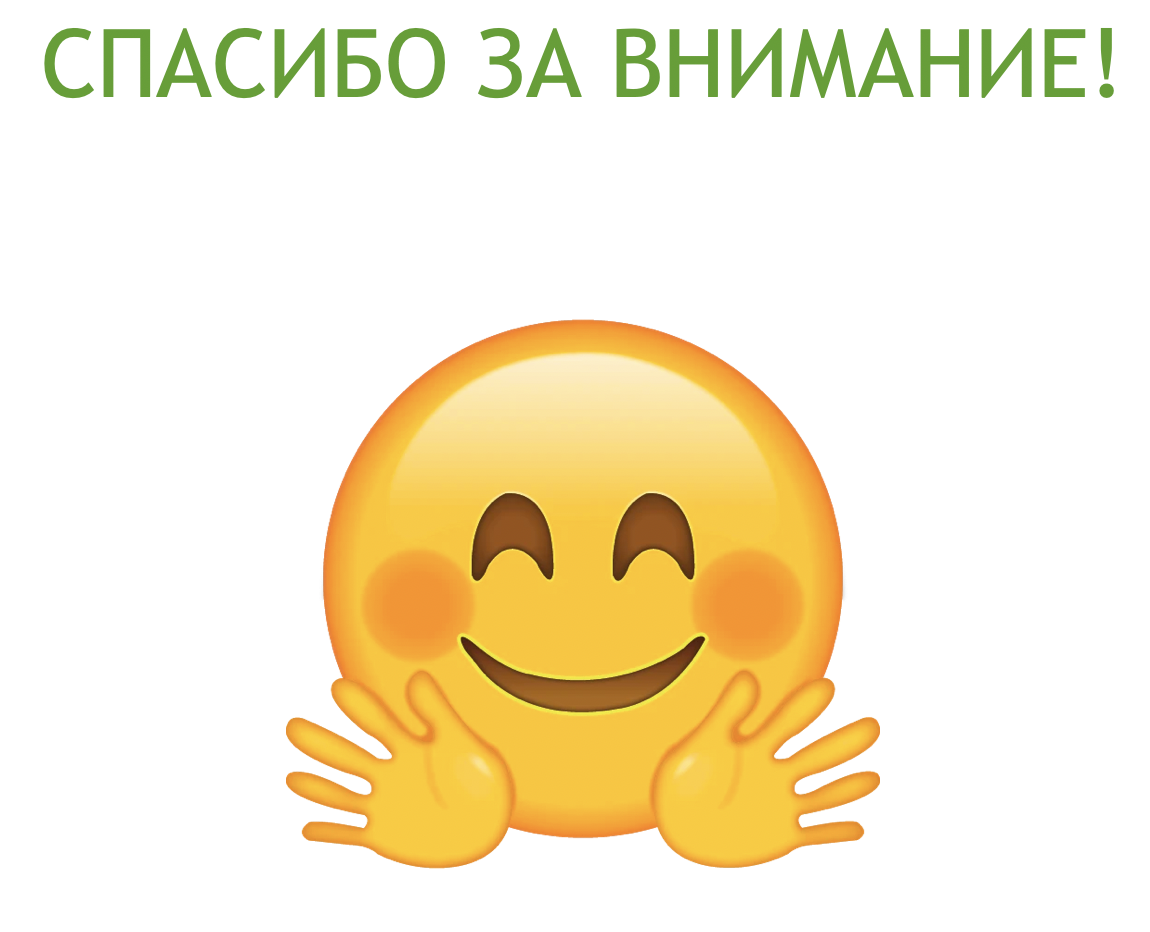

(5000,)